In [1]:
import pylab
from matplotlib import gridspec
import matplotlib.pyplot as plt 
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os

import sklearn
import torch
from nerus import load_nerus

np.random.seed(1)
import random

In [2]:
docs = load_nerus('nerus/nerus_lenta.conllu.gz')

In [3]:
doc = next(docs)

In [5]:
i = 0
for sent in doc.sents:
    for token in sent.tokens:
        i += 1
        if(token.pos != "X" and token.pos != "PUNCT"):
            print("{}\n\t\t:\t{}".format(token.text,token.pos))
        if(i > 10):
            break
    if(i > 10):
        break

Вице-премьер
		:	NOUN
по
		:	ADP
социальным
		:	ADJ
вопросам
		:	NOUN
Татьяна
		:	PROPN
Голикова
		:	PROPN
рассказала
		:	VERB
в
		:	ADP
каких
		:	DET
регионах
		:	NOUN


In [6]:
selLen = 1000 #рассматриваем первые 1000 документов

In [7]:
maxlen = 0

In [8]:
for i in range (selLen): #Ищем максимальную длину
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                
                if( len(token.text) > maxlen ):
                    maxlen = len(token.text)

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

In [9]:
maxlen

34

In [10]:
larrXX = []
larrLB = []

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                
                 if(len(token.text) <= maxlen ): #на всякий случай
                        larrXX.append([char for char in token.text] + [' ' for i in range(maxlen - len(token.text))])
                        larrLB.append([token.pos]) #мб стоит преобразовать в численный тег

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

In [11]:
for i in range(10):
    print("{}\n\t\t:\t{}".format(larrXX[i],larrLB[i])) #вариант обработанного для подачи на вход классификатру текста

['В', 'и', 'ц', 'е', '-', 'п', 'р', 'е', 'м', 'ь', 'е', 'р', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
		:	['NOUN']
['п', 'о', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
		:	['ADP']
['с', 'о', 'ц', 'и', 'а', 'л', 'ь', 'н', 'ы', 'м', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
		:	['ADJ']
['в', 'о', 'п', 'р', 'о', 'с', 'а', 'м', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
		:	['NOUN']
['Т', 'а', 'т', 'ь', 'я', 'н', 'а', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
		:	['PROPN']
['Г', 'о', 'л', 'и', 'к', 'о', 'в', 'а', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 

##### проверяем реализуемость задачи

Визуализирвать  
        - распределение длин по классам (+)       
        - наиболее часто встречающиеся буквы на позициях по классам (+)  
        

##### насколько это все надо?

Сравнить точность с программным морфемным разбором  
По идее точность определения с помощью классификатора должна быть ниже, вопрос – насколько  
 Если не особо ниже (2-5 %), то приемлемо  
 Если почти не ниже (0-2 %), то этот метод не так уж плох  
 Если точность этого метода выше, то он применим в качестве метода классификации слов

###### Срочный чек-лист  

- сформировать набор классов (+)

###### Возможные проблемы

- дискретность входных параметров (букв на позиции). Насколько такое классифицируемо?

#### Определяем, какие могут быть классы

In [72]:
def includes(arr,elm):
    for a in arr:
        if(a == elm):
            return True
    return False

In [73]:
Classes = []

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                
                 if(not includes(Classes,token.pos)): #на всякий случай
                        Classes.append(token.pos)

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

In [74]:
Classes

['NOUN',
 'ADP',
 'ADJ',
 'PROPN',
 'VERB',
 'DET',
 'ADV',
 'PRON',
 'CCONJ',
 'SCONJ',
 'NUM',
 'PART',
 'AUX',
 'INTJ']

In [233]:
ClassesRU = ["СУЩ","ПРЕД","ПРИЛ","ИМЯ","ГЛАГ","МЕСТ","НАР","МЕСТ","СЧСОЮЗ","ПДСОЮЗ","ЧИСЛ","ПРИЧ","БЫТЬ","МЕЖДОМ"]

In [234]:
ClassesRU

['СУЩ',
 'ПРЕД',
 'ПРИЛ',
 'ИМЯ',
 'ГЛАГ',
 'МЕСТ',
 'НАР',
 'МЕСТ',
 'СЧСОЮЗ',
 'ПДСОЮЗ',
 'ЧИСЛ',
 'ПРИЧ',
 'БЫТЬ',
 'МЕЖДОМ']

In [227]:
def ClassConvToRU(cl):
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return ClassesRU[i]
        
def ClassConvToEN(cl):
    for i in range(len(Classes)):
        if(cl == ClassesRU[i]):
            return Classes[i]

### Распределение длинн по классам

In [75]:
def classnum(cl): #перевод из имен классов в индексы
    for i in range(len(Classes)):
        if(cl == Classes[i]):
            return i
    return -1

In [76]:
CllenAvg = [0 for i in range(len(Classes))] #среднее значение длины слова соответствующего класса
Clcnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

In [77]:
CllenAvg

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [78]:
CllenAvg = [0 for i in range(len(Classes))] #среднее значение длины слова соответствующего класса
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов собираем данные по словам и тегам в массивы
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                clN = classnum(token.pos)
                CllenAvg[clN] += len(token.text)
                ClCnt[clN] += 1
                
for i in range(len(Classes)):
    CllenAvg[i] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

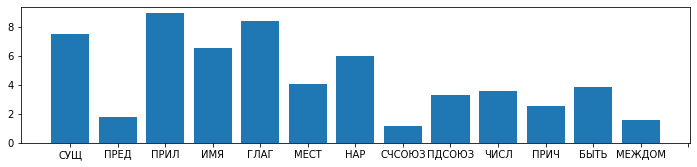

In [239]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(2.5) 

ax.bar(ClassesRU,CllenAvg)
pylab.xticks(np.arange(14))
pylab.show()

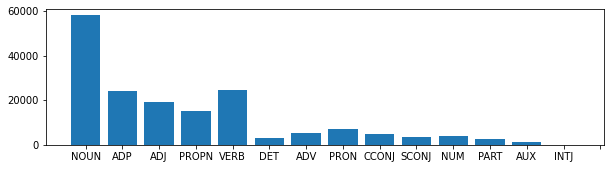

In [81]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(2.5) 

ax.bar(Classes,ClCnt)
pylab.xticks(np.arange(15))
pylab.show()

Ну в принципе можно отделить длинные части речи от коротких, как один из параметров пойдет

### Наиболее частые буквы по классам

##### Первая позиция  

In [125]:
alphabet = ['а', 'е', 'ё', 'и', 'о', 'у', 'ы', 'э', 'ю', 'я', 
            'б', 'в', 'г', 'д', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т', 'ф', 'х', 'ц', 'ч', 'ш', 'щ',
            'ь', 'ъ']

In [205]:
ClassFreqFST = [[0 for i in range(len(alphabet))] for i in range(len(Classes))] 
    #для каждого класса массив с количеством стреченных букв

In [206]:
def LetterPos(l):
    for i in range (len(alphabet)):
        if(l == alphabet[i]):
            return i
    return -1

In [207]:
ClassFreqFST = [[0 for i in range(len(alphabet))] for i in range(len(Classes))] #для каждого класса массив с количеством стреченных букв
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов 
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                lp = LetterPos(token.text.lower()[0])
                if(lp >= 0):
                    clN = classnum(token.pos)
                    ClassFreqFST[clN][lp] += 1
                    ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqFST[i][j] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Частотность букв на первой позиции в слове


СУЩ


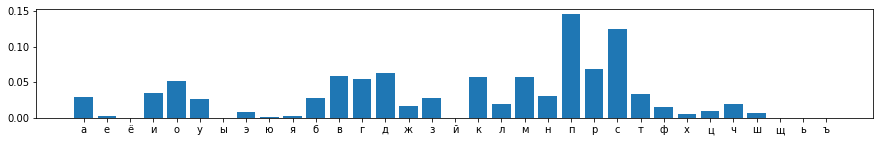

ПРЕД


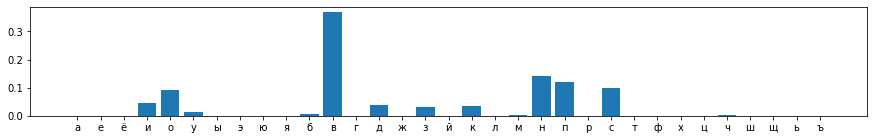

ПРИЛ


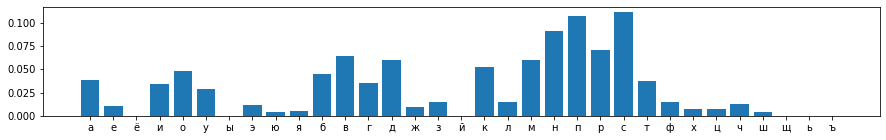

ИМЯ


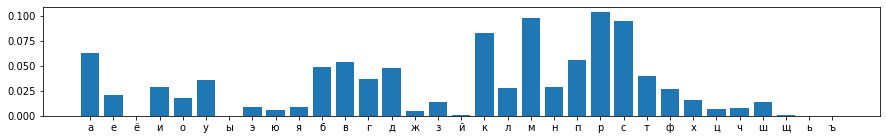

ГЛАГ


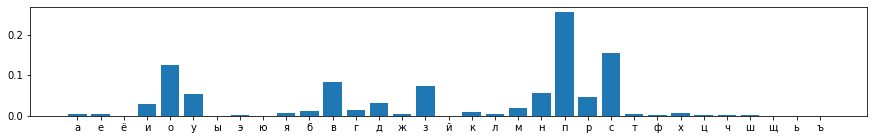

МЕСТ


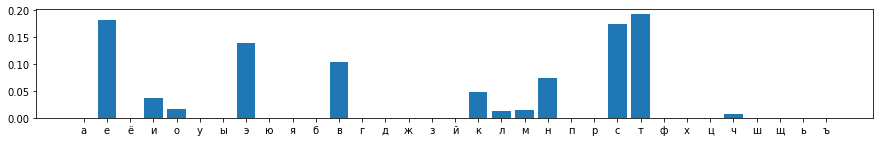

НАР


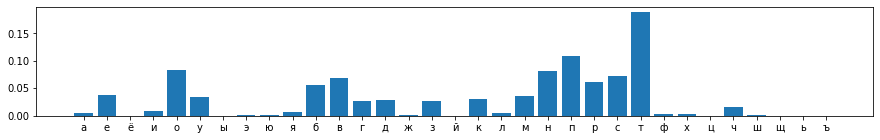

МЕСТ


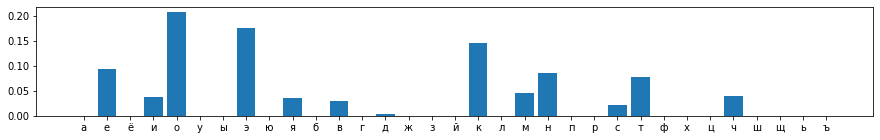

СОЧСОЮЗ


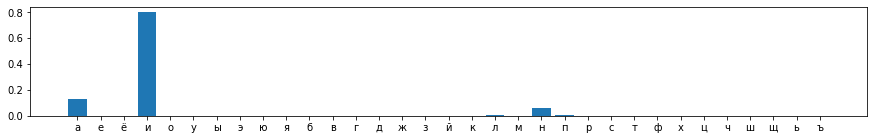

ПОДЧСОЮЗ


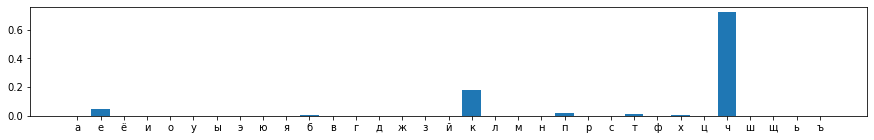

ЧИСЛ


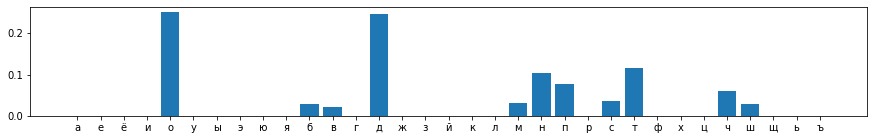

ПРИЧ


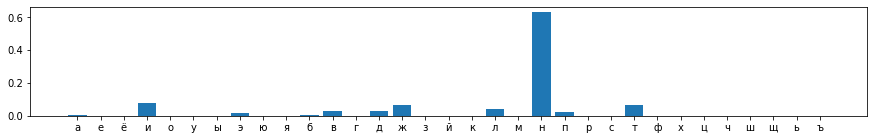

БЫТЬ


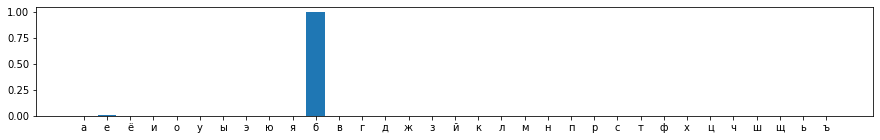

МЕЖДОМ


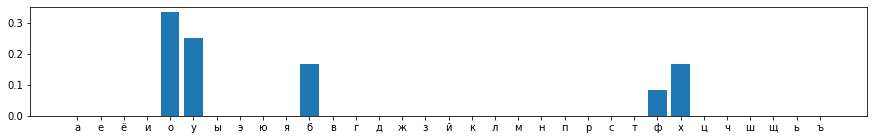

In [209]:
print("Частотность букв на первой позиции в слове\n\n")

for i in range(len(Classes)): 
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print(ClassConvToRU(Classes[i]))
    ax.bar(alphabet,ClassFreqFST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

Сравниваем классы подвое:

In [210]:
def overlay(i,j, freq):
    try:
        s1 = int(i)
    except(BaseException):
        s1 = int(classnum(i))
    
    try:
        s2 = int(j)
    except(BaseException):
        s2 = int(classnum(j))
        
    
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(3) 
    
    a = np.arange(len(alphabet))
    
    ax.bar(a + 0.2,freq[s1],width = 0.4,label = Classes[s1])
    ax.bar(a - 0.2,freq[s2],width = 0.4,label = Classes[s2])
    
    ax.set_xticks(a)
    ax.set_xticklabels(alphabet)
    ax.legend()
    
    pylab.xticks(np.arange(33))
    pylab.show()
    

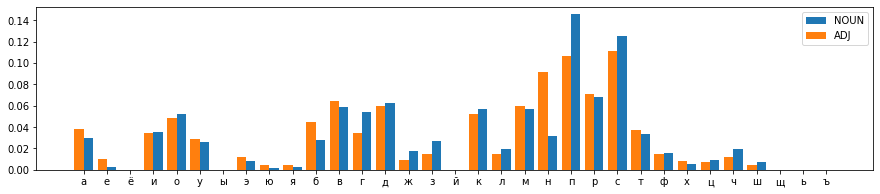

In [241]:
overlay(ClassConvToEN("СУЩ"),ClassConvToEN("ПРИЛ"), ClassFreqFST)

Существительные с прилагательными по первой букве очень уж похожи, но чтобы другие части речи отличать пригодится 

##### Последняя позиция  

In [213]:
ClassFreqLST = [[0 for i in range(len(alphabet))] for i in range(len(Classes))] #для каждого класса массив с количеством стреченных букв
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                lp = LetterPos(token.text.lower()[len(token.text) - 1])
                if(lp >= 0):
                    clN = classnum(token.pos)
                    ClassFreqLST[clN][lp] += 1
                    ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqLST[i][j] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Частотность букв на первой позиции в слове


СУЩ


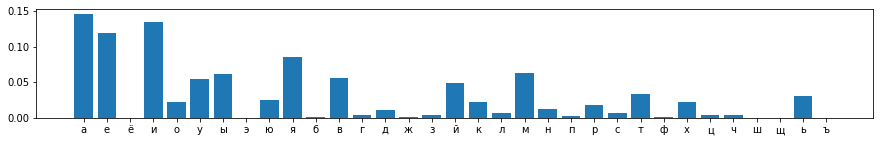

ПРЕД


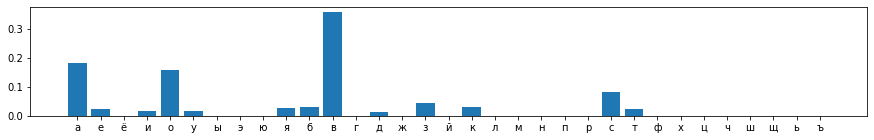

ПРИЛ


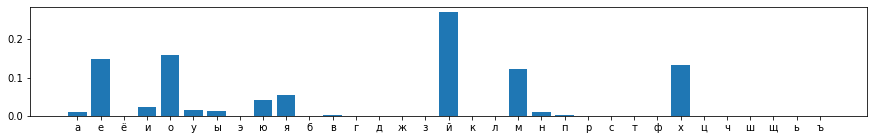

ИМЯ


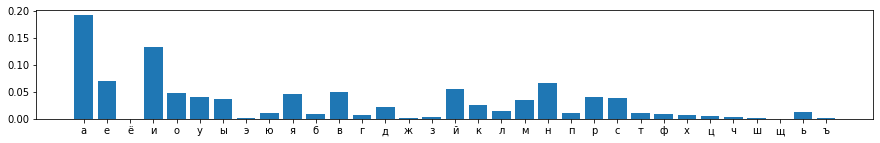

ГЛАГ


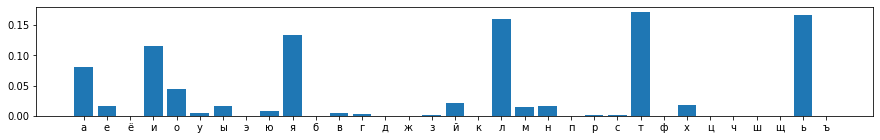

МЕСТ


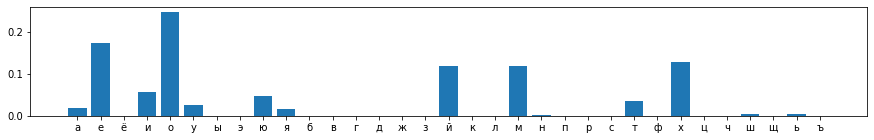

НАР


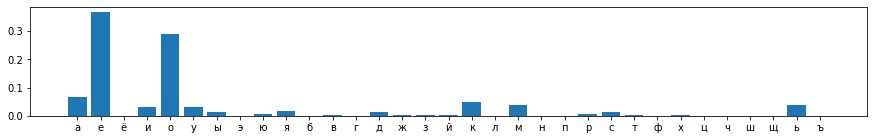

МЕСТ


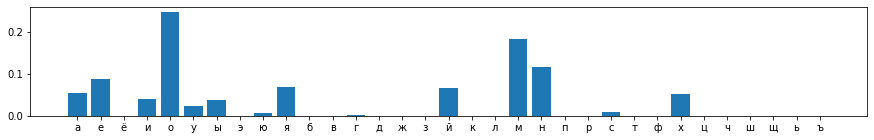

СЧСОЮЗ


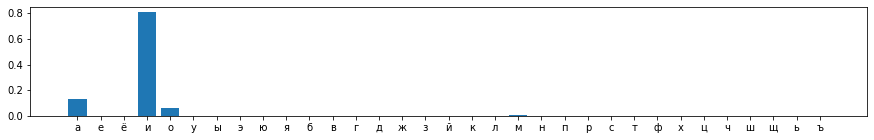

ПДСОЮЗ


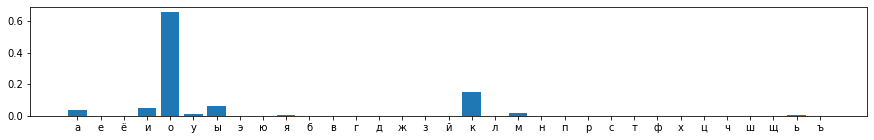

ЧИСЛ


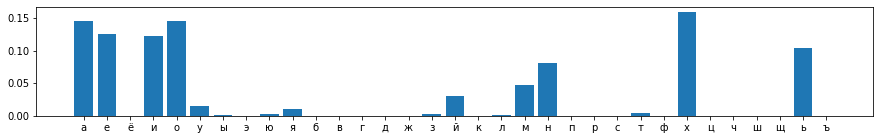

ПРИЧ


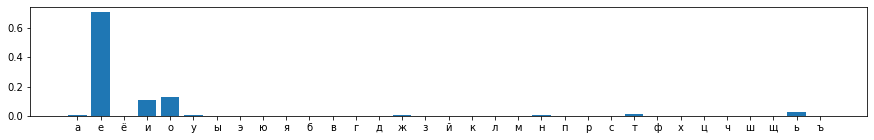

БЫТЬ


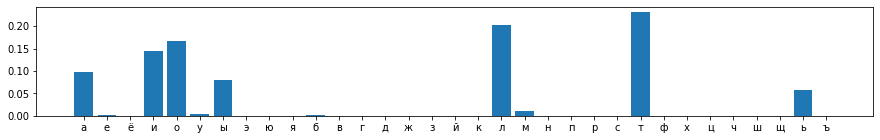

МЕЖДОМ


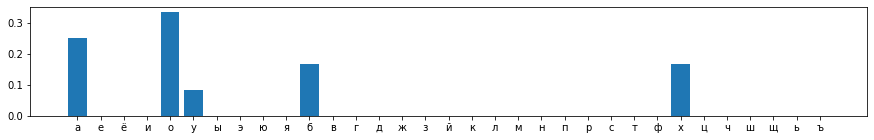

In [242]:
print("Частотность букв на последней позиции в слове\n\n")

for i in range(len(Classes)): 
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print(ClassConvToRU(Classes[i]))
    ax.bar(alphabet,ClassFreqLST[i])
    pylab.xticks(np.arange(33))
    pylab.show()

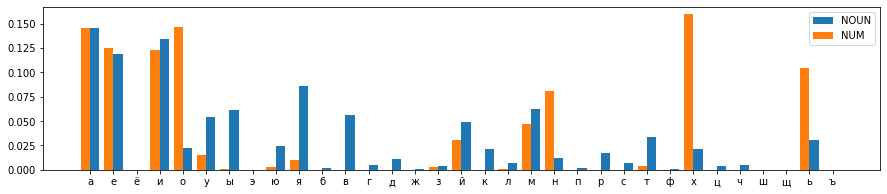

In [246]:
overlay(ClassConvToEN("СУЩ"),ClassConvToEN("ЧИСЛ"), ClassFreqLST)

Супер большие различия почти по всем частям речи, однозначно хорший признак

#### Предпоследняя позиция

In [244]:
ClassFreqPLS = [[0 for i in range(len(alphabet))] for i in range(len(Classes))] #для каждого класса массив с количеством стреченных букв
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов 
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                if(len(token.text) - 2 >= 0):
                    lp = LetterPos(token.text.lower()[len(token.text) - 2])
                    if(lp >= 0):
                        clN = classnum(token.pos)
                        ClassFreqPLS[clN][lp] += 1
                        ClCnt[clN] += 1
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqPLS[i][j] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Частотность букв на предпоследней позиции в слове


СУЩ


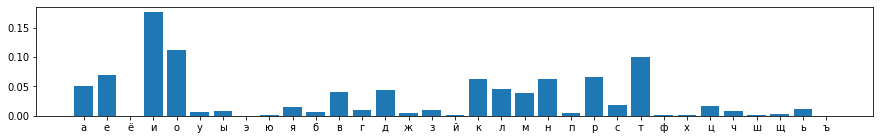

ПРЕД


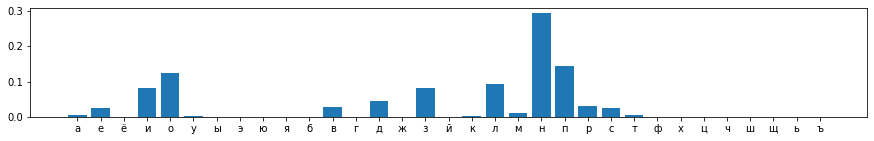

ПРИЛ


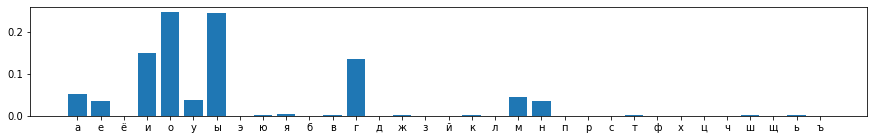

ИМЯ


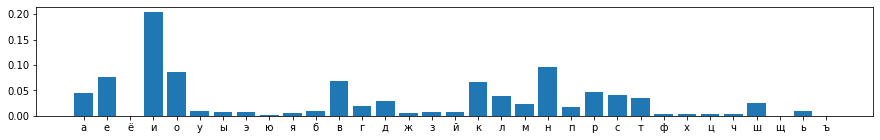

ГЛАГ


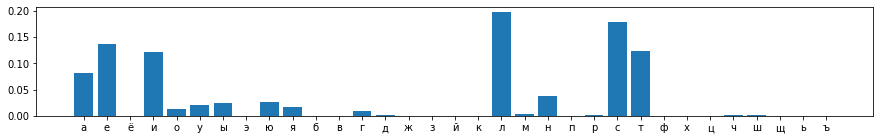

МЕСТ


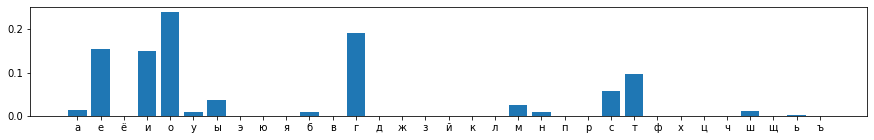

НАР


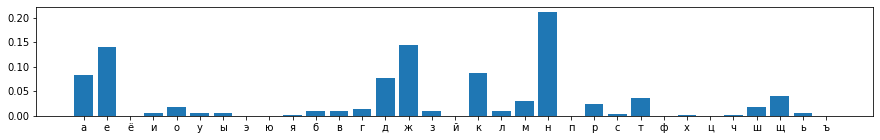

МЕСТ


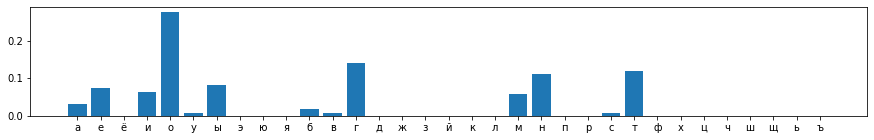

СЧСОЮЗ


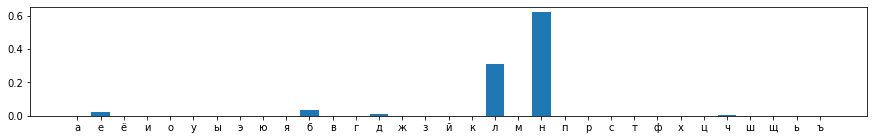

ПДСОЮЗ


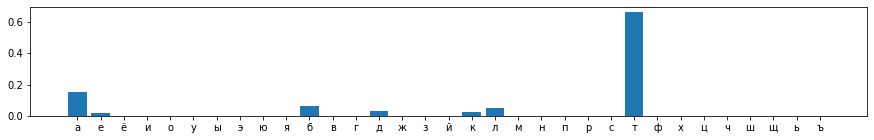

ЧИСЛ


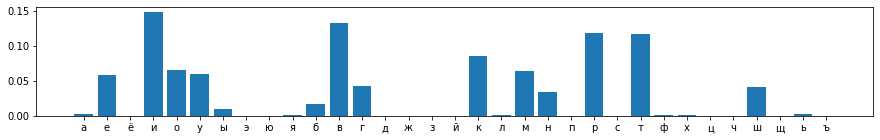

ПРИЧ


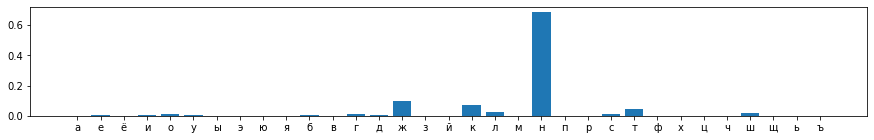

БЫТЬ


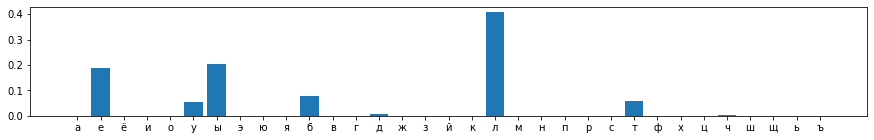

МЕЖДОМ


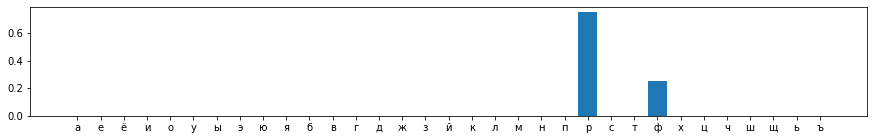

In [245]:
print("Частотность букв на предпоследней позиции в слове\n\n")

for i in range(len(Classes)): 
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print(ClassConvToRu(Classes[i]))
    ax.bar(alphabet,ClassFreqPLS[i])
    pylab.xticks(np.arange(33))
    pylab.show()

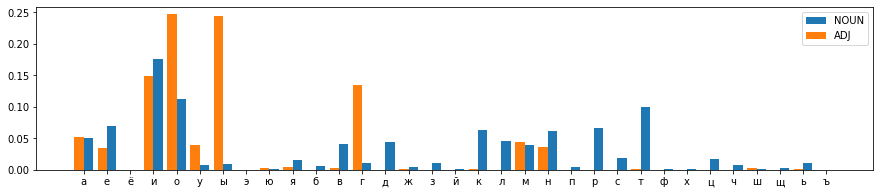

In [248]:
overlay(ClassConvToEN("СУЩ"),ClassConvToEN("ПРИЛ"), ClassFreqPLS)

То же, что и с последней позицией, местами даже лучше

##### Средняя частота встречаемости во всем слове

здесь массив заполняется так: выполняется проход по слову, и все его буквы отмечаются в смиске как встреченные в данном классе  
При этом деление в конце выполняется не на количество встреенных слов данного класса, а на сумму их дилн

In [222]:
ClassFreqOVL = [[0 for i in range(len(alphabet))] for i in range(len(Classes))] #для каждого класса массив с количеством стреченных букв
ClCnt = [0 for i in range(len(Classes))] #сколько слов каждого класса встретилось

for i in range (selLen): #рассматриваем первые 1000 документов
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                for a in token.text.lower():
                    lp = LetterPos(a)
                    if(lp >= 0):
                        clN = classnum(token.pos)
                        ClassFreqOVL[clN][lp] += 1
                        ClCnt[clN] += len(token.text)
                
for i in range(len(Classes)):
    for j in range(len(alphabet)):
        if(ClCnt[i] != 0):
            ClassFreqOVL[i][j] /= ClCnt[i]

docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

СУЩ


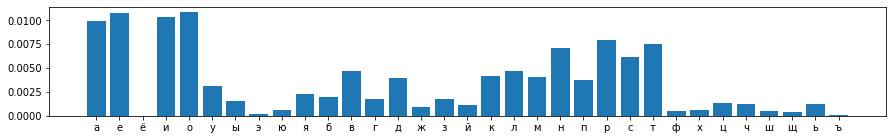

ПРЕД


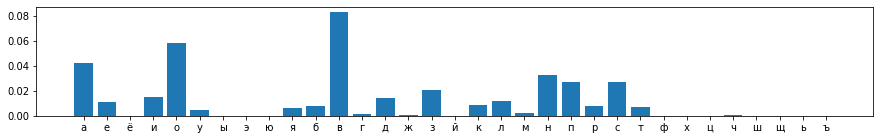

ПРИЛ


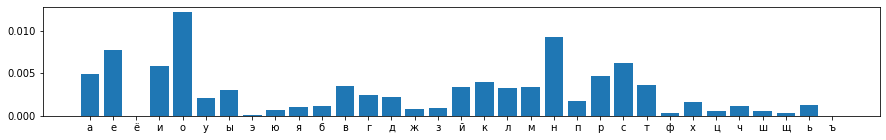

ИМЯ


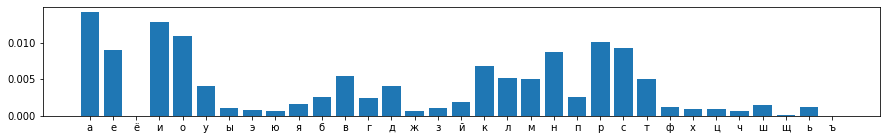

ГЛАГ


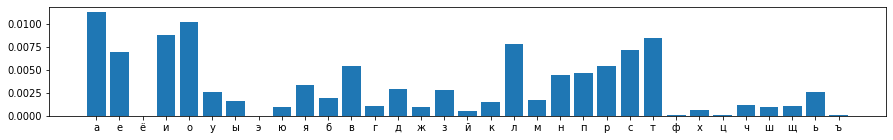

МЕСТ


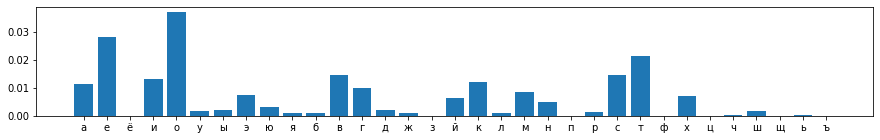

НАР


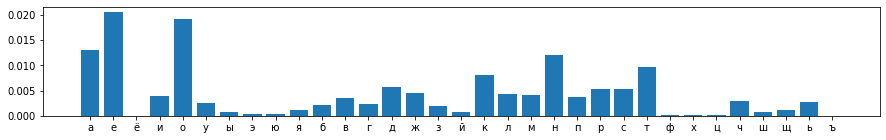

МЕСТ


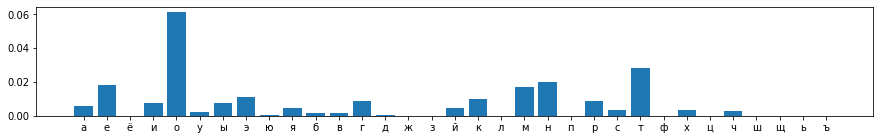

СОЧСОЮЗ


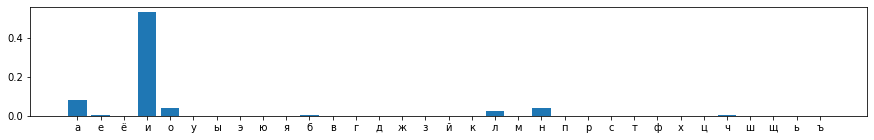

ПОДЧСОЮЗ


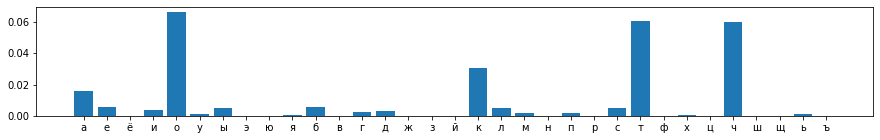

ЧИСЛ


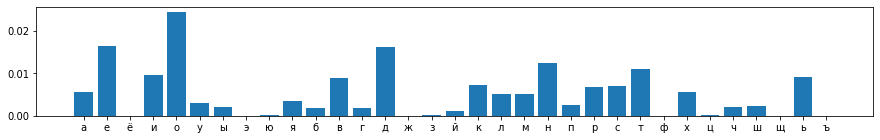

ПРИЧ


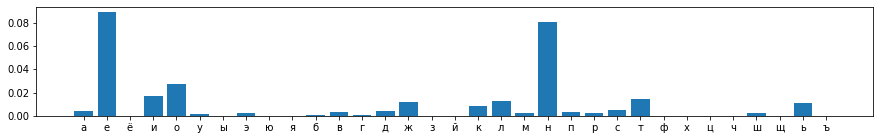

БЫТЬ


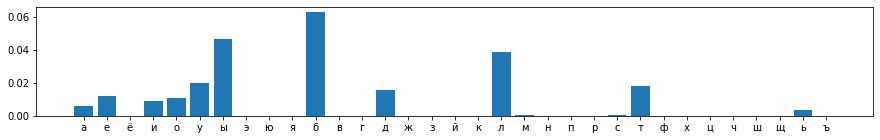

МЕЖДОМ


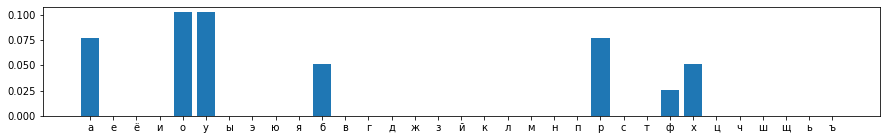

In [223]:
for i in range(len(Classes)): 
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(2) 

    print(ClassConvToRu(Classes[i]))
    ax.bar(alphabet,ClassFreqOVL[i])
    pylab.xticks(np.arange(33))
    pylab.show()

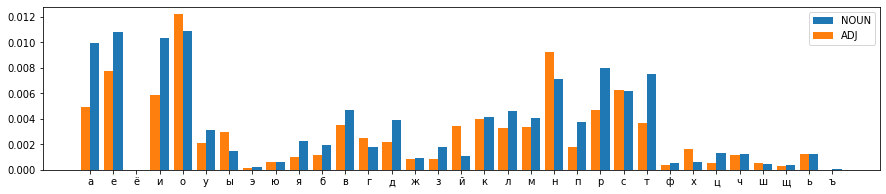

In [249]:
overlay(ClassConvToEN("СУЩ"),ClassConvToEN("ПРИЛ"), ClassFreqOVL)

Тут как-то уныло, да и непонятно, как реализовывать этот признак

Если надо посмотреть на примеры слов определенного класса

In [188]:
for i in range (selLen): #рассматриваем первые 1000 документов
    doc = next(docs)
    for sent in doc.sents:
        for token in sent.tokens:
            if(token.pos != "X" and token.pos != "PUNCT" and token.pos != "SYM"):
                if(token.pos == "INTJ"):
                    print(token.text)
                
docs = load_nerus('nerus/nerus_lenta.conllu.gz') # "сдвигаем" итератор в начало

Фу
О
О
ура
ура
ура
х
б
О
х
б
О
